<a href="https://colab.research.google.com/github/madhumitadange/Generate-Source-Galaxy-Images-from-Strong-Gravitational-Lens-Images/blob/main/Copy_of_CS230StrongGravitatialLensingPart2_v1Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strong Gravitatial Lensing : Generate Original galaxy image using U-Net




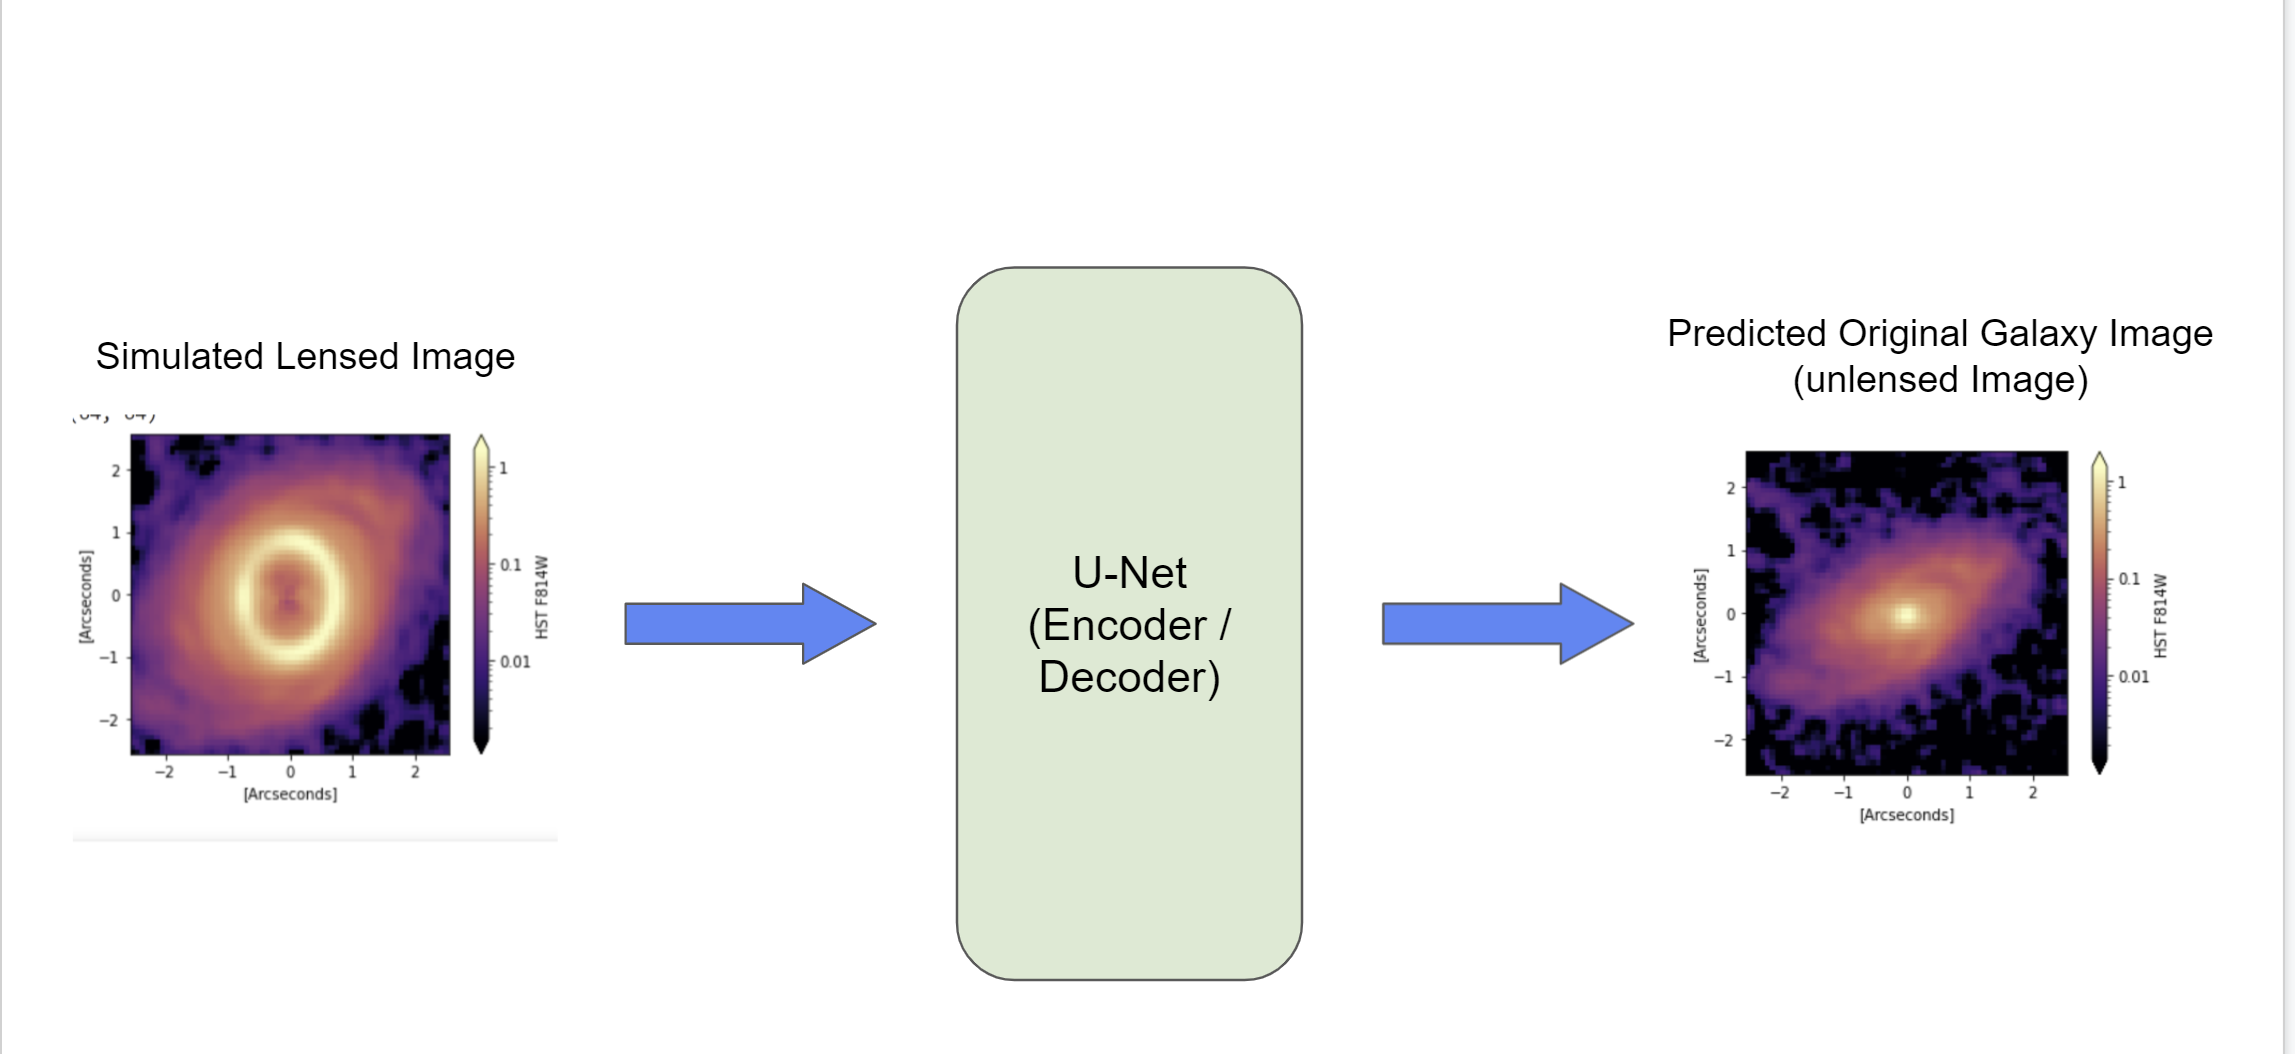

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import sys
import random
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,BatchNormalization,Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from skimage.metrics import structural_similarity as ssim,peak_signal_noise_ratio as psnr,mean_squared_error as mse

Read Data created by lenstronamy. Details about Preproccessing, data augmentation, test train, dev split etc in another Notebook 

In [ ]:

zip_ref = zipfile.ZipFile("/content/drive/My Drive/CS230/ProjectData.zip", 'r')
zip_ref.extractall("/CS230")
zip_ref.close()

#Helper Function to plot Lensed and Unlensed images
Ref: https://github.com/JelleAalbers/minilensmaker/tree/main/minilensmaker

In [ ]:
def exporter():
    """Export utility modified from https://stackoverflow.com/a/41895194
    Returns export decorator, __all__ list
    """
    all_ = []

    def decorator(obj):
        all_.append(obj.__name__)
        return obj

    return decorator, all_


export, __all__ = exporter()
__all__.append("exporter")


@export
def image_grid(
    shape,
    pixel_width,
    x0=0,
    y0=0,
    edges=True,
):
    nx, ny = shape
    dx = nx * pixel_width
    dy = nx * pixel_width
    extra = 1 if edges else 0
    x = np.linspace(-dx / 2, dx / 2, nx + extra) + x0
    y = np.linspace(-dy / 2, dy / 2, ny + extra) + y0
    return x, y


@export
def plot_image(
    img,
    pixel_width,
    log_scale=True,
    label="HST F814W",
    colorbar=True,
    adjust_ax=True,
    vmin=None,
    vmax=None,
    **kwargs
):

    # Set reasonable defaults
    if vmax is None:
        vmax = img.max()
    if vmin is None:
        if log_scale:
            vmin = vmax * 1e-3
        else:
            vmin = img.min()
    kwargs.setdefault(
        "norm",
        matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
        if log_scale
        else matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
    )
    kwargs.setdefault("cmap", "magma")

    # Plot image, note transposition
    plt.pcolormesh(
        *image_grid(img.shape, pixel_width), img.clip(vmin, None).T, **kwargs
    )
    if adjust_ax:
        plt.gca().set_aspect("equal")

    if colorbar:
        # Plot colorbar
        cbar = plt.colorbar(label=label, extend="both")
        cax = cbar.ax
        # Format colobar ticks as scalars (not 10^x)
        cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
        if len(cbar.get_ticks()) < 2:
            # If there are very few colorbar ticks, show minor ticks too
            cax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
            cax.tick_params(axis="y", labelsize=7, which="minor")

    plt.xlabel("[Arcseconds]")
    plt.ylabel("[Arcseconds]")


@export
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(
        matplotlib.patches.Rectangle(
            (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor="none", **kwargs
        )
    )#

In [ ]:
from skimage import measure
def compare_images(target, ref):
    target = np.squeeze(target/255)
    ref = np.squeeze(ref/255)
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores
# Loss functtion
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
def psnr_loss(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, 1.0)
def mse_ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)) + 1- tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
!ls /

bin	 CS230	  etc	lib32  mnt   root  srv		      tmp    var
boot	 datalab  home	lib64  opt   run   sys		      tools
content  dev	  lib	media  proc  sbin  tensorflow-1.15.2  usr


In [ ]:
datafile = np.load("/CS230/ProjectData/train/Lensed/24178.npy")
np.amax(datafile)

1.5125014509087362

Visualized Gravitatinal lensing image

(64, 64)


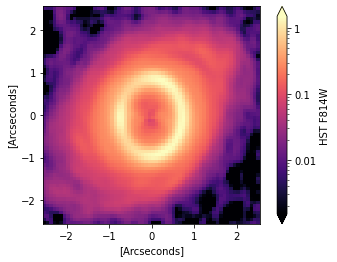

In [ ]:
plot_image(datafile,pixel_width=0.08)
print(datafile.shape)

Visualization of Training data 

/CS230/ProjectData/train/Lensed/19477.npy
20211


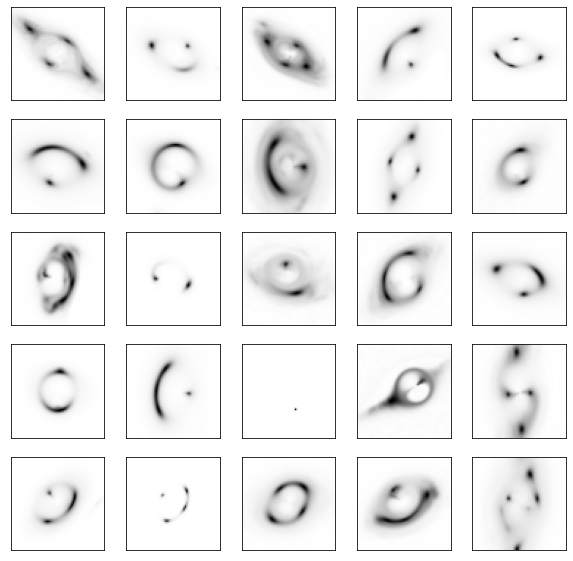

In [ ]:
train_url = "/CS230//ProjectData/train/Lensed"

import pathlib

data = pathlib.Path('ProjectData.zip', train_url)
train_images = list(data.glob('*.npy'))

print(train_images[0])
print(len(train_images))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.load(train_images[i]) / 255
    plt.imshow(img, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Read Train Images and Train labels. Output layer is 8 continuous parameters 

In [ ]:
trainPara = pd.read_csv("/CS230/ProjectData/trainParameters.csv")
#print(trainPara["source_rotation"].dtype)
#display(trainPara)
#print(trainPara.columns)
#trainFeatureName = trainPara["fileName"]
# train_images #/CS230/ProjectData/train/Lensed/52730_5.720406822933091.npy

trainLensedImage = []
trainUnlensedImage = []

for i in tqdm(range(trainPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/train/Lensed/"+trainPara['fileName'][i].astype(str)+'.npy')
    label = np.load("/CS230/ProjectData/train/Unlensed/"+trainPara['fileName'][i].astype(str)+'.npy')
    trainLensedImage.append(img)
    trainUnlensedImage.append(label)
  except:
    #continue
    print("/CS230/ProjectData/train/Lensed/"+trainPara['fileName'][i].astype(str))

xTrainLensed = np.array(trainLensedImage)
print(xTrainLensed.shape)
xTrainUnlensed = np.array(trainUnlensedImage)
print(xTrainUnlensed.shape)

#trainLabels = trainPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
##print(trainLabels.head())
#print(trainFeatureName.head())


100%|██████████| 20211/20211 [00:14<00:00, 1406.43it/s]


(20211, 64, 64)
(20211, 64, 64)


Read Dev Images and Dev labels.

In [ ]:
devPara = pd.read_csv("/CS230/ProjectData/devParameters.csv")
devLensedImage = []
devUnlensedImage = []

for i in tqdm(range(devPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/dev/Lensed/"+devPara['fileName'][i].astype(str)+'.npy')
    label = np.load("/CS230/ProjectData/dev/Unlensed/"+devPara['fileName'][i].astype(str)+'.npy')
    devLensedImage.append(img)
    devUnlensedImage.append(label)
  except:
    #continue
    print("/CS230/ProjectData/dev/Lensed/"+devPara['fileName'][i].astype(str))

xDevLensed = np.array(devLensedImage)
print(xDevLensed.shape)
xDevUnlensed = np.array(devUnlensedImage)
print(xDevUnlensed.shape)

#devLabels = devPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
#print(devLabels.head())


100%|██████████| 1977/1977 [00:01<00:00, 1297.85it/s]


(1977, 64, 64)
(1977, 64, 64)


Read Test Images and Test labels.

In [ ]:
testPara = pd.read_csv("/CS230/ProjectData/testParameters.csv")
testLensedImage = []
testUnlensedImage = []

for i in tqdm(range(testPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/test/Lensed/"+testPara['fileName'][i].astype(str)+'.npy')
    label = np.load("/CS230/ProjectData/test/Unlensed/"+testPara['fileName'][i].astype(str)+'.npy')

    testLensedImage.append(img)
    testUnlensedImage.append(label)
  except:
    #continue
    print("/CS230/ProjectData/test/Lensed/"+testPara['fileName'][i].astype(str))

xTestLensed = np.array(testLensedImage)
print(xTestLensed.shape)
xTestUnlensed = np.array(testUnlensedImage)
print(xTestUnlensed.shape)
#testLabels = testPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
#print(testLabels.head())

100%|██████████| 1992/1992 [00:01<00:00, 1365.58it/s]


(1992, 64, 64)
(1992, 64, 64)


Train Different U-Net Models

In [ ]:
inputs = Input((64, 64, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='linear') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 16)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
outputs.shape

TensorShape([None, 64, 64, 1])

In [ ]:
inputs = Input((64, 64, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (p2)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='linear') (c9)

model2 = Model(inputs=[inputs], outputs=[outputs])
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 16)   160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 64, 64, 16)   0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [ ]:
inputs = Input((64, 64, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (p2)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='linear') (c9)

model3 = Model(inputs=[inputs], outputs=[outputs])
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 64, 64, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 16)   160         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 64, 64, 16)   0           conv2d_28[0][0]                  
____________________________________________________________________________________________

In [ ]:
inputs = Input((64, 64, 1))
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (inputs)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(16, (3, 3), padding='same',use_bias=False) (inputs)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3),  padding='same',use_bias=False) (p1)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c2)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (p2)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), padding='same', use_bias=False) (p3)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(128, (3, 3), padding='same',use_bias=False) (c4)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), padding='same',use_bias=False) (p4)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(256, (3, 3),  padding='same',use_bias=False) (c5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (u6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (c6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (u7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (u8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (u9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)
c9 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)

out = Conv2D(1, (1, 1), use_bias=False) (c9)
out = BatchNormalization()(out)
outputs = Activation('linear')(out)

model4 = Model(inputs=[inputs], outputs=[outputs])
model4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 64, 64, 16)   144         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 64, 64, 16)   64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 64, 64, 16)   0           batch_normalization_77[0][0]     
____________________________________________________________________________________________

In [ ]:
inputs = Input((64, 64, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (s)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c1)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3),  padding='same',use_bias=False) (p1)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c2)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (p2)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), padding='same', use_bias=False) (p3)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(128, (3, 3), padding='same',use_bias=False) (c4)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), padding='same',use_bias=False) (p4)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(256, (3, 3),  padding='same',use_bias=False) (c5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (u6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (c6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (u7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (u8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (u9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)
c9 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)

out = Conv2D(1, (1, 1), use_bias=False) (c9)
out = BatchNormalization()(out)
outputs = Activation('linear')(out)
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model5 = Model(inputs=[inputs], outputs=[outputs])
model5.compile(loss=ssim_loss, optimizer=optimizer, metrics=['mse',ssim_loss])
model5.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 64, 64, 1)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 64, 64, 16)   144         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 64, 64, 16)   64          conv2d_190[0][0]                 
___________________________________________________________________________________________

In [ ]:
inputs = Input((64, 64, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (s)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c1)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3),  padding='same',use_bias=False) (p1)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c2)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (p2)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), padding='same', use_bias=False) (p3)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(128, (3, 3), padding='same',use_bias=False) (c4)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), padding='same',use_bias=False) (p4)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(256, (3, 3),  padding='same',use_bias=False) (c5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (u6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (c6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (u7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (u8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (u9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)
c9 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)

out = Conv2D(1, (1, 1), use_bias=False) (c9)
out = BatchNormalization()(out)
outputs = Activation('linear')(out)
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model6 = Model(inputs=[inputs], outputs=[outputs])
model6.compile(loss=mse_ssim_loss, optimizer=optimizer, metrics=['mse',ssim_loss,psnr_loss])
model6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   144         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
compare_images(x_dev[1],x_dev[1])

NameError: ignored

In [ ]:
history5 = model5.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 21s 29ms/step - loss: 0.3961 - mse: 0.9142 - ssim_loss: 0.3961 - val_loss: 0.8146 - val_mse: 0.0482 - val_ssim_loss: 0.8146
Epoch 2/20
632/632 [==============================] - 18s 28ms/step - loss: 0.1401 - mse: 0.7834 - ssim_loss: 0.1401 - val_loss: 0.1364 - val_mse: 1.0919 - val_ssim_loss: 0.1365
Epoch 3/20
632/632 [==============================] - 18s 28ms/step - loss: 0.1141 - mse: 0.7651 - ssim_loss: 0.1141 - val_loss: 0.1171 - val_mse: 1.3111 - val_ssim_loss: 0.1171
Epoch 4/20
632/632 [==============================] - 18s 28ms/step - loss: 0.0964 - mse: 0.7577 - ssim_loss: 0.0964 - val_loss: 0.4068 - val_mse: 0.3878 - val_ssim_loss: 0.4066
Epoch 5/20
632/632 [==============================] - 18s 28ms/step - loss: 0.0850 - mse: 0.7551 - ssim_loss: 0.0850 - val_loss: 0.2464 - val_mse: 0.7370 - val_ssim_loss: 0.2464
Epoch 6/20
632/632 [==============================] - 18s 29ms/step - loss: 0.0763 - mse: 0.7506 - ssim_loss: 

Reshape data 

In [ ]:
x_train = xTrainLensed.reshape(-1,64, 64, 1)
x_trainLabel = xTrainUnlensed.reshape(-1,64, 64, 1)

x_dev = xDevLensed.reshape(-1, 64, 64, 1)
x_devLabel = xDevUnlensed.reshape(-1, 64, 64, 1)

x_test = xTestLensed.reshape(-1, 64, 64, 1)
x_testLabel = xTestUnlensed.reshape(-1, 64, 64, 1)


In [ ]:
history6 = model6.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 55s 30ms/step - loss: 0.9307 - mse: 0.5079 - ssim_loss: 0.4228 - psnr_loss: 9.4974 - val_loss: 0.6983 - val_mse: 0.0185 - val_ssim_loss: 0.6797 - val_psnr_loss: 21.0655
Epoch 2/20
632/632 [==============================] - 17s 27ms/step - loss: 0.2151 - mse: 0.0894 - ssim_loss: 0.1258 - psnr_loss: 17.7779 - val_loss: 0.1161 - val_mse: 0.0057 - val_ssim_loss: 0.1105 - val_psnr_loss: 25.8892
Epoch 3/20
632/632 [==============================] - 17s 28ms/step - loss: 0.1179 - mse: 0.0142 - ssim_loss: 0.1037 - psnr_loss: 24.2459 - val_loss: 0.1186 - val_mse: 0.0101 - val_ssim_loss: 0.1085 - val_psnr_loss: 25.3539
Epoch 4/20
632/632 [==============================] - 17s 28ms/step - loss: 0.0886 - mse: 0.0054 - ssim_loss: 0.0832 - psnr_loss: 27.4585 - val_loss: 0.1281 - val_mse: 0.0046 - val_ssim_loss: 0.1235 - val_psnr_loss: 27.7301
Epoch 5/20
632/632 [==============================] - 18s 28ms/step - loss: 0.0792 - mse: 0.0048 - ssim_l

In [ ]:
history1 = model.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 50s 25ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0385 - mape: 5692942.7066 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0258 - val_mape: 4720977.0000
Epoch 2/20
632/632 [==============================] - 14s 23ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0235 - mape: 2726411.7733 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0184 - val_mape: 2353529.7500
Epoch 3/20
632/632 [==============================] - 15s 23ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0218 - mape: 2262169.5122 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0174 - val_mape: 1181603.6250
Epoch 4/20
632/632 [==============================] - 15s 23ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0201 - mape: 1935761.3154 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0160 - val_mape: 835282.9375
Epoch 5/20
632/632 [==============================] - 15s 23ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0195 - mape: 1875937.4240 - val_loss: 0.0055 - 

Compile and train the model

In [ ]:
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

history2 = model2.fit(x_train, x_trainLabel,batch_size=32, epochs=5, validation_data=(x_dev, x_devLabel))

Epoch 1/5
632/632 [==============================] - 12s 18ms/step - loss: 0.0310 - mse: 0.0310 - mae: 0.0516 - mape: 7065749.5576 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0329 - val_mape: 4789290.5000
Epoch 2/5
632/632 [==============================] - 11s 18ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.0353 - mape: 4285570.8562 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0298 - val_mape: 3074975.2500
Epoch 3/5
632/632 [==============================] - 11s 18ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.0335 - mape: 4074338.9155 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0255 - val_mape: 2267737.0000
Epoch 4/5
632/632 [==============================] - 11s 18ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0315 - mape: 3607585.6453 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0280 - val_mape: 4111837.2500
Epoch 5/5
632/632 [==============================] - 11s 18ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0304 - mape: 3620005.7844 - val_loss: 0.0110 - val_

In [ ]:
history3 = model3.fit(x_train, x_trainLabel,batch_size=32, epochs=10, validation_data=(x_dev, x_devLabel))

Epoch 1/10
632/632 [==============================] - 12s 17ms/step - loss: 0.0306 - mse: 0.0306 - mae: 0.0413 - mape: 5264455.6295 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0244 - val_mape: 1254766.7500
Epoch 2/10
632/632 [==============================] - 10s 16ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0277 - mape: 1711942.6390 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0279 - val_mape: 2815963.2500
Epoch 3/10
632/632 [==============================] - 10s 17ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0261 - mape: 1552686.8584 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0228 - val_mape: 1541281.7500
Epoch 4/10
632/632 [==============================] - 10s 16ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0250 - mape: 1418443.7075 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0212 - val_mape: 996074.3125
Epoch 5/10
632/632 [==============================] - 10s 16ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0247 - mape: 1518394.0963 - val_loss: 0.0108 - 

In [ ]:
history4 = model4.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 9s 13ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.0748 - mape: 11655441.3025 - val_loss: 0.0150 - val_mse: 0.0150 - val_mae: 0.0393 - val_mape: 7038860.5000
Epoch 2/20
632/632 [==============================] - 8s 12ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0359 - mape: 4627052.4581 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0542 - val_mape: 12988696.0000
Epoch 3/20
632/632 [==============================] - 8s 12ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0321 - mape: 3939918.9775 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0474 - val_mape: 9016083.0000
Epoch 4/20
632/632 [==============================] - 8s 12ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0297 - mape: 3389232.7200 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0306 - val_mape: 4472354.0000
Epoch 5/20
632/632 [==============================] - 8s 12ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0277 - mape: 3050947.5221 - val_loss: 0.0121 - va

In [ ]:
history4 = model4.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 14s 20ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.0440 - mape: 5845833.0296 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.0275 - val_mape: 2870211.0000
Epoch 2/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0059 - mse: 0.0059 - mae: 0.0196 - mape: 1697396.4706 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0216 - val_mape: 1484499.5000
Epoch 3/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0169 - mape: 1026282.5646 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0208 - val_mape: 1647871.3750
Epoch 4/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0162 - mape: 993176.4106 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0172 - val_mape: 1474812.5000
Epoch 5/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0160 - mape: 1052273.6203 - val_loss: 0.0039 - 

In [ ]:
historyT = model4.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 14s 19ms/step - loss: 0.4911 - mse: 0.4911 - mae: 0.2097 - mape: 44064933.4376 - val_loss: 0.3391 - val_mse: 0.3391 - val_mae: 0.1279 - val_mape: 18078492.0000
Epoch 2/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0621 - mse: 0.0621 - mae: 0.0657 - mape: 12505887.6746 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0295 - val_mape: 3714858.0000
Epoch 3/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0210 - mape: 2435419.2342 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0149 - val_mape: 612416.0625
Epoch 4/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0153 - mape: 1017547.7155 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0179 - val_mape: 1153703.5000
Epoch 5/20
632/632 [==============================] - 12s 19ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0148 - mape: 999363.9848 - val_loss: 0.0032 

In [ ]:
!pip install numpy==1.19.5

In [ ]:
test_results = model6.predict(x_test)

In [ ]:
test_results.shape

(1992, 64, 64, 1)

In [ ]:
id =2
pred =(np.squeeze(test_results[id]))
lab =(np.squeeze(x_testLabel[id]))

img =(np.squeeze(x_test[id]))

(64, 64)


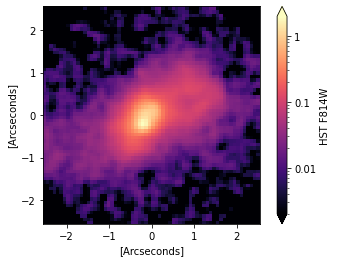

In [ ]:
plot_image(lab,pixel_width=0.08)
#plot_image(pred,pixel_width=0.08)

print((np.squeeze(test_results[id])).shape)

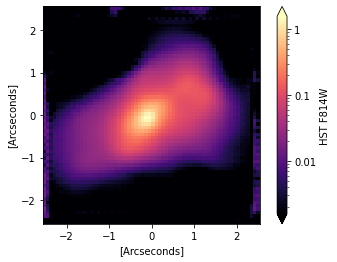

In [ ]:
plot_image(pred,pixel_width=0.08)

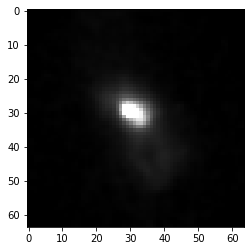

In [ ]:
from PIL import Image
image_from_array = Image.fromarray(pred)
plt.imshow(lab, cmap='gray',clim=(0,1))

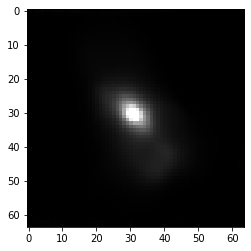

In [ ]:
plt.imshow(pred, cmap='gray',clim=(0,1))

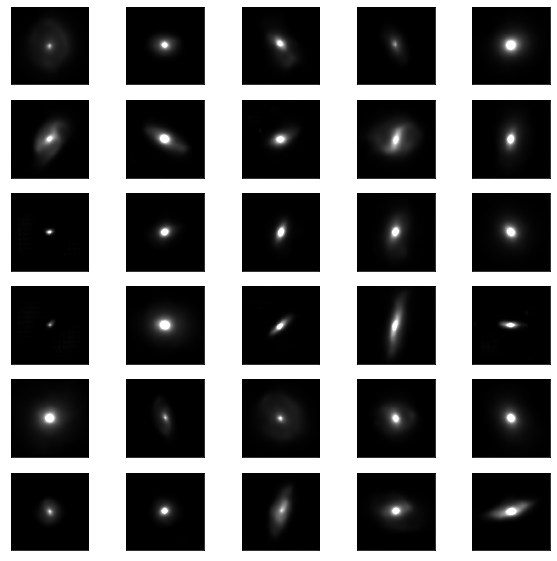

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.squeeze(test_results[i])
    label = np.squeeze(x_testLabel[i])  
    plt.imshow(img, cmap='gray',clim=(0,1))

plt.show()

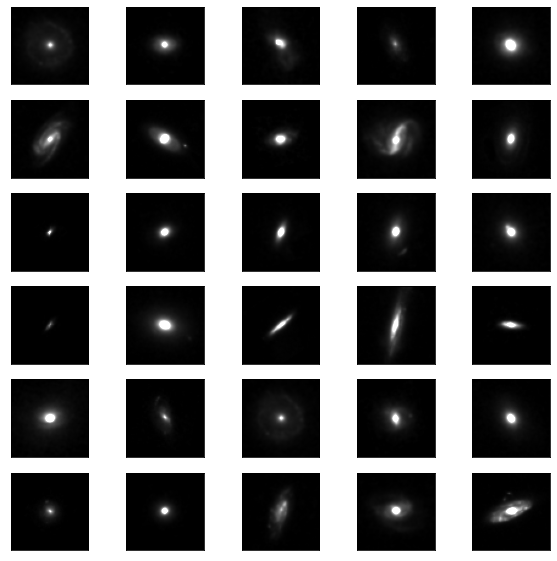

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.squeeze(x_testLabel[i]) 
    plt.imshow(img, cmap='gray',clim=(0,1))
plt.show()

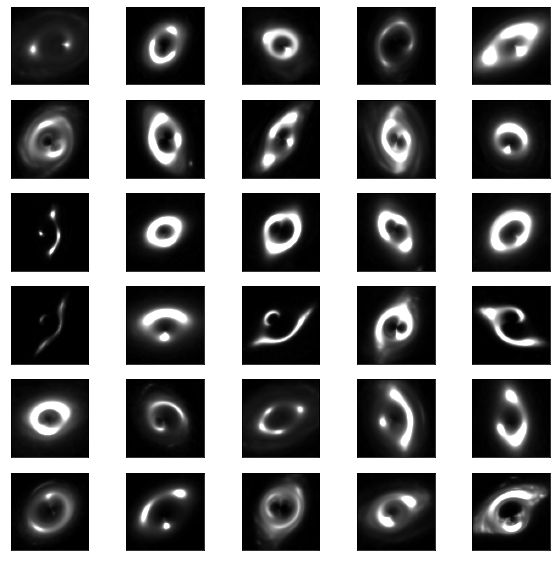

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.squeeze(x_test[i]) 
    plt.imshow(img, cmap='gray',clim=(0,1))
plt.show()

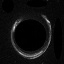

In [ ]:
img = Image.open('gl.jpg').convert('L')
img = img.resize((64, 64), Image.ANTIALIAS)
pic1 = np.array(img)
pic.shape
pic =  pic1.reshape(-1, 64, 64, 1)
pic.shape
img

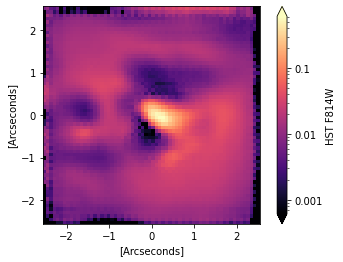

In [ ]:
picresult = model6.predict(pic/255)
id =2
pred =(np.squeeze(picresult))

img =(np.squeeze(pic))
plot_image(pred,pixel_width=0.08)

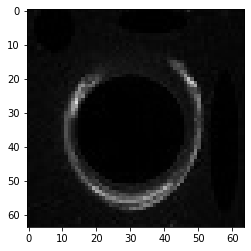

In [ ]:
plt.imshow(pic1/255, cmap='gray',clim=(0,1))

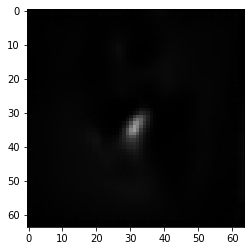

In [ ]:
plt.imshow(pred, cmap='gray',clim=(0,1))

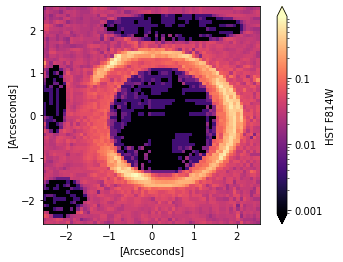

In [ ]:
plot_image(pic1/255,pixel_width=0.08)

NameError: ignored

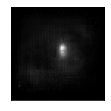

In [ ]:
# Plotting both resukt vs original in same view  
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.squeeze(test_results[i])
    plt.imshow(img, cmap='gray',clim=(0,1))


    plt1.subplot(5,3,i+1)
    plt1.xticks([])
    plt1.yticks([])
    plt1.grid(False)
    label = np.squeeze(x_testLabel[i])
    plt1.imshow(label, cmap='gray',clim=(0,1))
plt.show()

Visualize  results
Create plots of loss on the training and validation sets.

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
dev_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, dev_loss, 'b-')
plt.legend(['Training Loss', 'Dev Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

NameError: ignored

In [ ]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['mse'])

pyplot.show()

In [ ]:
pyplot.plot(history.history['mae'])
pyplot.show()

In [ ]:
pyplot.plot(history.history['mape'])
pyplot.show()

Analyze test results per output class 